<a href="https://colab.research.google.com/github/Gaci-git/MultiOutput-Classification-and-Regression-model-with-Tensorflow/blob/main/multioutput_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Club Machine Learning prediction using XGBoost, Optuna and Streamlit

Being able to accurately assess the risk of a loan application can save a lender the cost of holding too many risky assets. Rather than a credit score or credit history which tracks how reliable borrowers are, we will try to predict how profitable a loan will be compared to other loans in the past. 

Having an easy-to-interpret model that a loan officer can use to provide immediate estimates can not only speed up the process but also save lenders from potential losses.

* The first step of our plan is to create a machine learning model to classify loans into paid / charged off* so that we can start learning if you have enough data to solve this simple problem adequately. 

* The second step is to predict the grade for the loan

*  the third step is to predict the subgrade and the interest rate.

* and finally, deploy a fully-working deployed model that your company can use. Excitedly you get to work!


** A charge-off is a debt, for example on a credit card, that is deemed unlikely to be collected by the creditor because the borrower has become substantially delinquent after a period of time. However, a charge-off does not mean a write-off of the debt entirely. Having a charge-off can mean serious repercussions on your credit history and future borrowing ability.

# Column meaning

* **loan_amnt**	The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* **term**	The number of payments on the loan. Values are in months and can be either 36 or 60.
* **int_rate**	Interest Rate on the loan
* **installment**	The monthly payment owed by the borrower if the loan originates.
* **grade**	LC assigned loan grade
* **sub_grade**	LC assigned loan subgrade
* **emp_length**	Employment length in years. Possible values are between 0 and * 10 where 0 means less than one year and 10 means ten or more years.
* **home_ownership**	The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
* **annual_inc**	The self-reported annual income provided by the borrower during registration.
* **verification_status**	Indicates if income was verified by LC, not verified, or if the income source was verified
* **issue_d**	The month which the loan was funded
* **loan_status**	Current status of the loan
* **purpose**	A category provided by the borrower for the loan request.
* **title**	The loan title provided by the borrower
* **zip_code**	The first 3 numbers of the zip code provided by the borrower in the loan application.
* **addr_state**	The state provided by the borrower in the loan application
* **dti**	A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* **earliest_cr_line**	The month the borrower's earliest reported credit line was opened
* **open_acc**	The number of open credit lines in the borrower's credit file.
* **pub_rec**	Number of derogatory public records
* **revol_bal**	Total credit revolving balance
* **revol_util**	Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* **total_acc**	The total number of credit lines currently in the borrower's credit file
* **initial_list_status**	The initial listing status of the loan. Possible values are – W, F
* **application_type**	Indicates whether the loan is an individual application or a joint application with two co-borrowers
* **mort_acc**	Number of mortgage accounts.
* **pub_rec_bankruptcies**	Number of public record bankruptcies

# Imports

In [ ]:
import numpy as np                              
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px                                   
import seaborn as sns                                               
import pandas as pd                                                             
import warnings                                                     
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats   
from sklearn.model_selection import train_test_split  
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV                             

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def plot_bar(dataframe, column_name):
  df1 = pd.DataFrame(dataframe, columns=[column_name, 'loan_status'])

  df_2 = df1.groupby([column_name, 'loan_status']).size().reset_index()
  df_2['percentage'] = dataframe.groupby([column_name, 'loan_status']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
  df_2.columns = [column_name, 'loan_status', 'Counts', 'Percentage']

  fig = px.bar(df_2, 
              x= column_name, 
              y=['Counts'], 
              color='loan_status', 
              color_continuous_scale=px.colors.diverging.Portland,
              text=df_2['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
  fig.update_coloraxes(showscale=False)

  fig.update_layout(
    autosize=False,
    width=1000,
    height=700)

  fig.show()


def plot_kde(column_name):
  str_only = df[df['loan_status'] == "Charged Off"]
  no_str_only = df[df['loan_status'] == "Fully Paid"]
  
  fig = plt.figure(figsize=(14,10))
  ax = fig.add_subplot()


  positive = pd.DataFrame(str_only[column_name])
  negative = pd.DataFrame(no_str_only[column_name])
  sns.kdeplot(positive[column_name], ax=ax,color="#0f4c81", shade=True, ec='black',label="Charged Off")
  sns.kdeplot(negative[column_name], ax=ax, color="#9bb7d4", shade=True, ec='black',label="Fully Paid")

  plt.ticklabel_format(style='plain')
  ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
  ax.xaxis.set_minor_formatter(mtick.ScalarFormatter())
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.legend()
  plt.show()


def draw_box_plot(dataframe):
  number = 0
  fig, ax = plt.subplots(1, 10, figsize=(24, 12))
  plt.subplots_adjust(wspace=1) 

  for column_name in column_names:
    sns.boxplot(data=df[column_name], ax=ax[number], palette = 'Blues')
    ax[number].set_xlabel(column_name)
    number += 1

  for subplot in ax:
    subplot.set_xticklabels([])
  plt.show()


# EDA

In [ ]:
df = pd.read_csv('/content/drive/My Drive/df.csv', index_col=[0])

In [ ]:
df.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status
0,100001133,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,...,15.0,0.0,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off
1,100001137,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,...,9.0,1.0,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid
2,100001158,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,...,11.0,0.0,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid
3,100001163,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,...,18.0,0.0,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off
4,100001282,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,...,10.0,0.0,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off


In [ ]:
df = df.drop(columns=['id'])
df.shape

(100000, 25)

## Outliers

In [ ]:
column_names = [
 'loan_amnt',
 'installment',
 'annual_inc',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'pub_rec_bankruptcies']

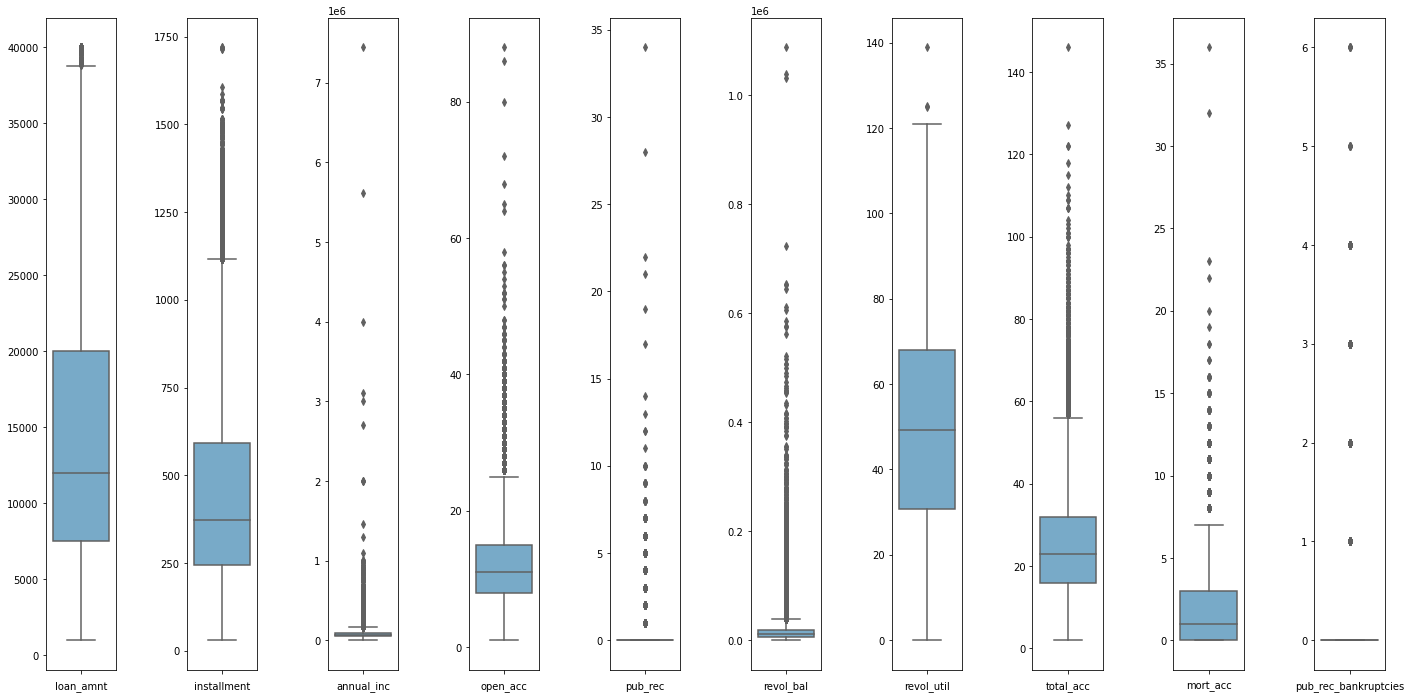

In [ ]:
draw_box_plot(df)

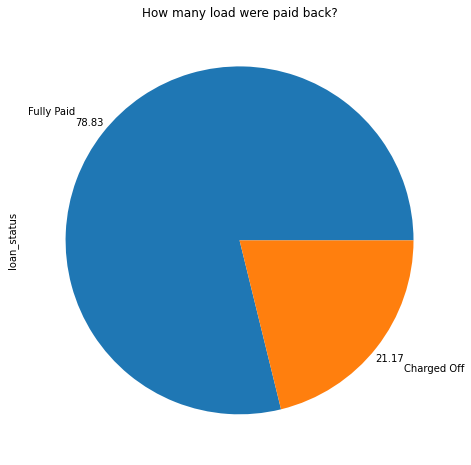

In [ ]:
fig = plt.figure(figsize =(8, 8))
df.loan_status.value_counts(normalize=True).plot.pie(autopct='%.2f', 
                                                 pctdistance=1.1, 
                                                 labeldistance=1.2)
plt.title('How many load were paid back?')
plt.show()

## Loan amount 

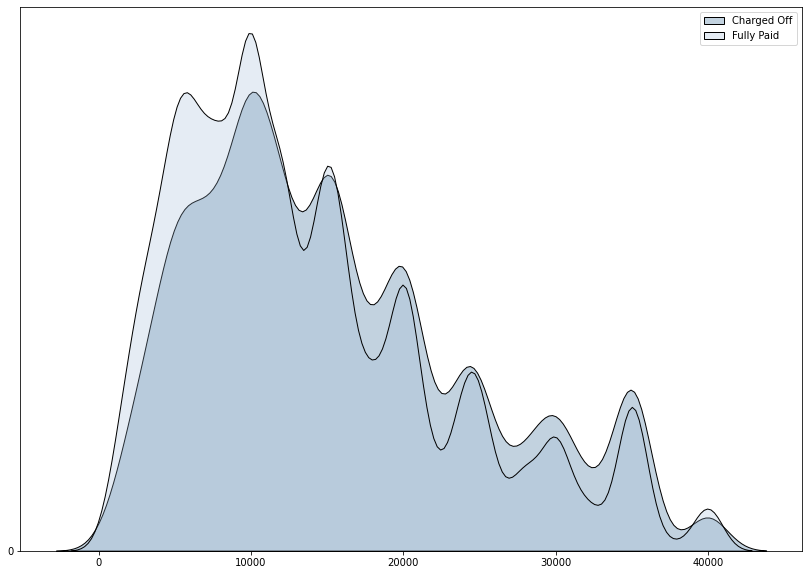

In [ ]:
plot_kde('loan_amnt')

Smaller loans tend to be Fully Paid more often

## Loan term

In [ ]:
plot_bar(df, 'term')

## Interest rate

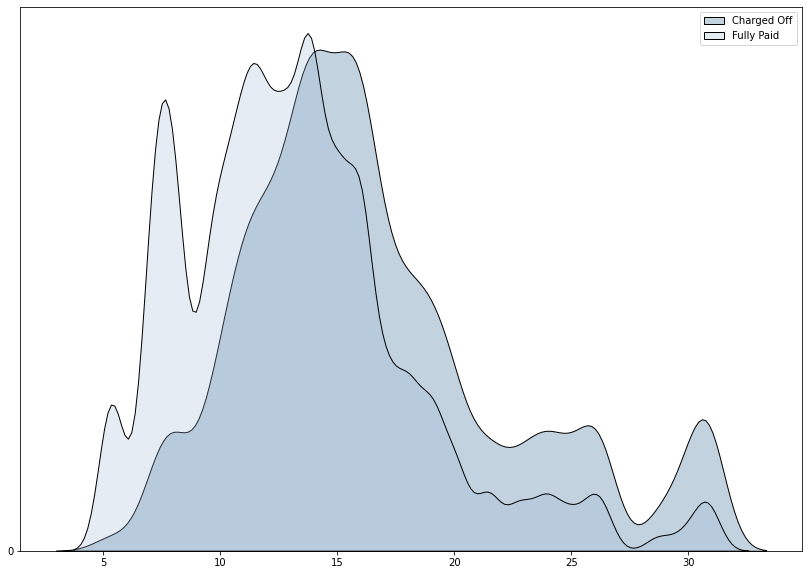

In [ ]:
plot_kde('int_rate')

Loans with smaller interest rate tend to be payed more often

## Loan grades

In [ ]:
plot_bar(df, 'grade')

The 'larger' the grade of the loan - the bigger the chance of this loan not being payed off. 

## Emplotement lenght

In [ ]:
plot_bar(df, 'emp_length')

## Home ownership 

In [ ]:
plot_bar(df, 'home_ownership')

## Annual income

In [ ]:
bins = (0, 50000, 60000, 70000, 80000, 90000, 100000, 500000, 1000000, 1100000)
labels = ['<50k','<60k', '<70k', '<80k', '<90k', '<100k', '<500k', '<1M', '<11M']
df['level_of_inc'] = pd.cut(x = df['annual_inc'], bins = bins, labels = labels)
df['level_of_inc'].value_counts()

<50k     28151
<500k    20773
<60k     13641
<70k     11841
<80k     10624
<90k      8020
<100k     6823
<1M        114
<11M         2
Name: level_of_inc, dtype: int64

In [ ]:
plot_bar(df, 'level_of_inc')

In [ ]:
df = df.drop(columns=['level_of_inc'])

## Application type

In [ ]:
plot_bar(df, 'application_type')

Interestly enough, those who have taken loan on their own, rather than sharing it, seems to have more success in paying it back. 

Or ... those who took Joint Application already had trouble by taking the loan at the first place

## Purpose

In [ ]:
df['purpose'] = df['purpose'].replace({'educational':'other'})
plot_bar(df, 'purpose')

# Feature engeneering: How fast the customer paid back

In [ ]:
df['last_pymnt_d']= pd.to_datetime(df['last_pymnt_d'])
df['issue_d']= pd.to_datetime(df['issue_d'])

df['time_paid_back'] = ((df['last_pymnt_d'] - df['issue_d'])/np.timedelta64(1, 'M'))
df = df.drop(columns=['last_pymnt_d', 'issue_d'])

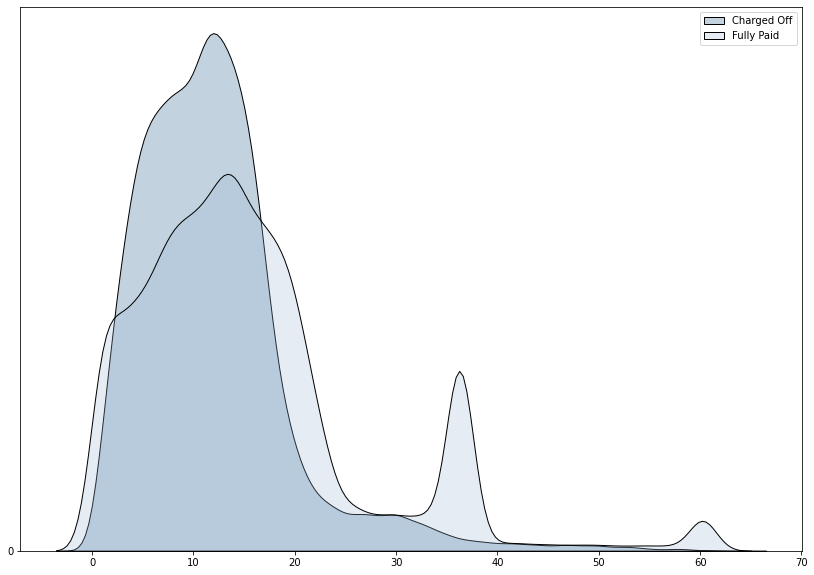

In [ ]:
plot_kde('time_paid_back')

## How long customer has a credit account

In [ ]:
df['earliest_cr_line']= pd.to_datetime(df['earliest_cr_line'])
df['cr_line'] = ((pd.to_datetime("now") - df['earliest_cr_line'])/np.timedelta64(1, 'Y'))
df = df.drop(columns=['earliest_cr_line'])

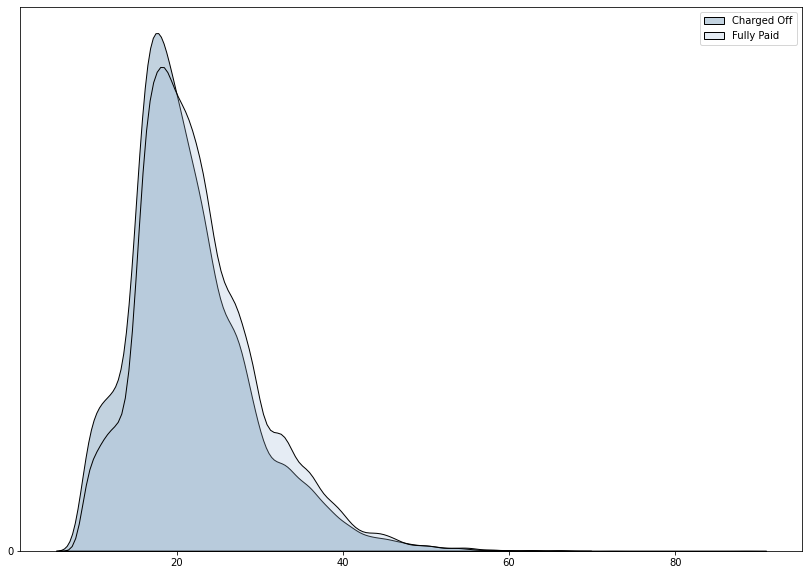

In [ ]:
plot_kde('cr_line')

# Mapping

In [ ]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,B,B1,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880142
1,7200.0,36 months,28.69,300.51,F,F1,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465644
2,7000.0,36 months,11.49,230.80,B,B5,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.715957
3,11200.0,36 months,13.99,382.74,C,C3,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794692
4,13200.0,36 months,19.99,490.50,D,D4,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211436


In [ ]:
grade_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
df.grade = df.grade.map(grade_mapping)

In [ ]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,1,B1,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880142
1,7200.0,36 months,28.69,300.51,5,F1,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465644
2,7000.0,36 months,11.49,230.80,1,B5,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.715957
3,11200.0,36 months,13.99,382.74,2,C3,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794692
4,13200.0,36 months,19.99,490.50,3,D4,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211436


In [ ]:
sub_grade_mapping = {'A1': 0, 'A2' : 1, 'A3': 2, 'A4': 3, 'A5': 4,
                     'B1': 5, 'B2' : 6, 'B3': 7, 'B4': 8, 'B5': 9,
                     'C1': 10, 'C2' : 11, 'C3': 12, 'C4': 13, 'C5': 14,
                     'D1': 15, 'D2' : 16, 'D3': 17, 'D4': 18, 'D5': 19,
                     'E1': 20, 'E2' : 21, 'E3': 22, 'E4': 23, 'E5': 24,
                     'F1': 25, 'F2' : 26, 'F3': 27, 'F4': 28, 'F5': 29,
                     'G1': 30, 'G2' : 31, 'G3': 32, 'G4': 33, 'G5': 34}
df.sub_grade = df.sub_grade.map(sub_grade_mapping)

In [ ]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,loan_status,time_paid_back,cr_line
0,30000.0,36 months,8.24,943.42,1,5,10+ years,OWN,132630.0,Source Verified,...,3444.0,5.3,22.0,w,Individual,2.0,0.0,Charged Off,23.064129,46.880142
1,7200.0,36 months,28.69,300.51,5,25,10+ years,MORTGAGE,73000.0,Verified,...,6501.0,28.8,13.0,f,Individual,0.0,1.0,Fully Paid,11.992033,27.465644
2,7000.0,36 months,11.49,230.80,1,9,9 years,MORTGAGE,60000.0,Not Verified,...,12916.0,54.5,21.0,w,Individual,1.0,0.0,Fully Paid,17.018830,17.715957
3,11200.0,36 months,13.99,382.74,2,12,3 years,RENT,60000.0,Verified,...,9686.0,40.9,33.0,f,Individual,0.0,0.0,Charged Off,18.037331,18.794692
4,13200.0,36 months,19.99,490.50,3,18,3 years,RENT,33000.0,Verified,...,9790.0,55.0,30.0,f,Individual,0.0,0.0,Charged Off,10.053595,14.211436


In [ ]:
employ_mapping = {'< 1 year': 0, 
                  '1 year': 1,
                  '2 years' : 2,
                  '3 years' : 3,
                  '4 years' : 4,
                  '5 years' : 5,
                  '6 years' : 6,
                  '7 years' : 7,
                  '8 years' : 8,
                  '9 years' : 9,
                  '10+ years' : 10}
df.emp_length = df.emp_length.map(employ_mapping)

In [ ]:
purpose_mapping = {'debt_consolidation': 0, 
                  'credit_card': 1,
                  'home_improvement': 2,
                  'other': 3,
                  'major_purchase': 4,
                  'car': 5,
                  'vacation': 6,
                  'moving': 7,
                  'house': 8,
                  'renewable_energy': 9,
                  'wedding': 10,
                  'medical': 11,
                  'small_business': 12}

df.purpose = df.purpose.map(lambda x: purpose_mapping.get(x,x))

In [ ]:
loan_status_mapping = {'Charged Off': 0, 
                  'Fully Paid': 1}
df.loan_status = df.loan_status.map(loan_status_mapping)


In [ ]:
categ = ['term', 'home_ownership', 'initial_list_status', 'application_type', 'verification_status']

le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)

# Hypotesis testing

A few points were not so clear to me.
* Is there really significant difference between 'Individual' loans and 'Joint Application Loans'? 
* Is employement lenght affecting the final outcome of the loan?



H0 => µ1 = µ2 (population mean of dataset1 is equal to dataset2)

HA => µ1 ≠µ2 (population mean of dataset1 is different from dataset2)


In [ ]:
stats.ttest_ind(df['emp_length'][df['loan_status'] == 1],
                df['emp_length'][df['loan_status'] == 0])

Ttest_indResult(statistic=11.255982251040646, pvalue=2.2539711968395243e-29)

In [ ]:
stats.ttest_ind(df['application_type'][df['loan_status'] == 1],
                df['application_type'][df['loan_status'] == 0])

Ttest_indResult(statistic=-6.935300707857561, pvalue=4.07805671802054e-12)

In [ ]:
stats.ttest_ind(df['cr_line'][df['loan_status'] == 1],
                df['cr_line'][df['loan_status'] == 0])

Ttest_indResult(statistic=18.477911310914884, pvalue=4.1664998967282175e-76)

# Correlations

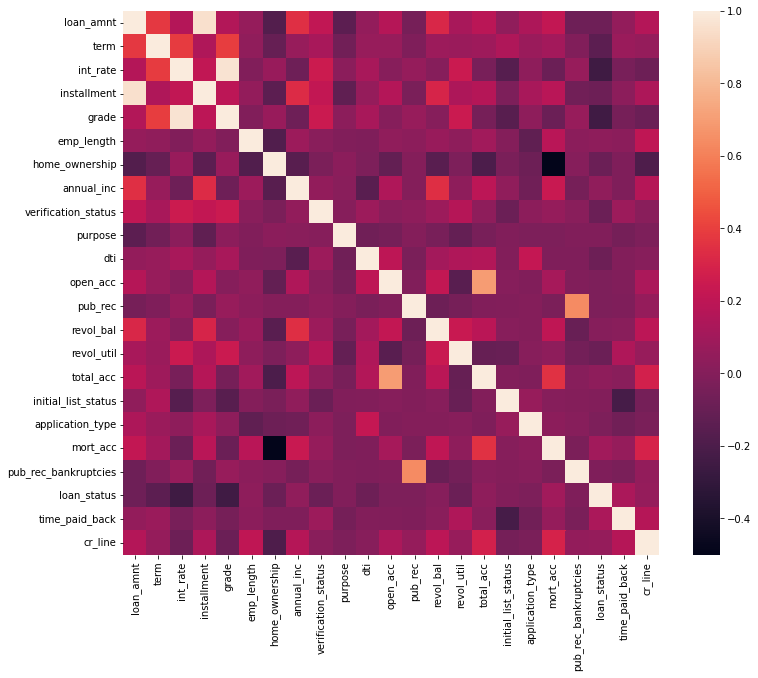

In [ ]:
fig = plt.figure(figsize= (12, 10))
corr = df.drop(['sub_grade'], axis=1).corr()
sns.heatmap(corr)
plt.show()

Although there is an indication of a higher correlation in the up left part of the graph when compared to the rest, the highest values were encountered for ProductRelated_Duration x ProductRelated and ExitRates x BounceRates. Therefore, I dropped ProductRelated_Duration and ExitRates from the features list that served as input to the models, and later to the GCP training as well.

In [ ]:
corr_matrix = df.corr()
print(corr_matrix["pub_rec"].sort_values(ascending=False))

pub_rec                 1.000000
pub_rec_bankruptcies    0.638372
sub_grade               0.065271
grade                   0.062851
cr_line                 0.062275
int_rate                0.060883
verification_status     0.037555
emp_length              0.032829
purpose                 0.002215
home_ownership          0.001399
application_type        0.001335
annual_inc             -0.000118
initial_list_status    -0.006338
total_acc              -0.010008
open_acc               -0.010742
term                   -0.013696
time_paid_back         -0.015145
loan_status            -0.020628
mort_acc               -0.030570
installment            -0.032472
dti                    -0.033015
loan_amnt              -0.045206
revol_util             -0.045389
revol_bal              -0.078626
Name: pub_rec, dtype: float64


In [ ]:
corr_matrix = df.corr()
print(corr_matrix["grade"].sort_values(ascending=False))

grade                   1.000000
sub_grade               0.974837
int_rate                0.966002
term                    0.393655
verification_status     0.245969
revol_util              0.244759
installment             0.195989
loan_amnt               0.159269
dti                     0.122329
home_ownership          0.070033
pub_rec_bankruptcies    0.064274
pub_rec                 0.062851
application_type        0.034467
purpose                 0.029790
open_acc                0.009049
revol_bal               0.005680
emp_length             -0.009391
time_paid_back         -0.045442
total_acc              -0.046104
annual_inc             -0.074626
cr_line                -0.087056
mort_acc               -0.089302
initial_list_status    -0.158641
loan_status            -0.247766
Name: grade, dtype: float64


In [ ]:
df = df.drop(columns=['installment', 'total_acc', 'pub_rec'])

comment on why dropping this.

# sub_grade and int_rate prediction

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

def format_output(data):
    y1 = data.pop('sub_grade')
    y1 = np.array(y1)
    y2 = data.pop('int_rate')
    y2 = np.array(y2)
    return y1, y2

In [ ]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2, random_state = 1)
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [ ]:
train_stats = train.describe()
train_stats.pop('sub_grade')
train_stats.pop('int_rate')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)
val_Y = format_output(val)

In [ ]:
norm_train_X = np.array(norm(train))
norm_test_X = np.array(norm(test))
norm_val_X = np.array(norm(val))

In [ ]:
def build_model():
    # Define model layers.
    input_layer = Input(shape=(len(train .columns),))
    first_dense = Dense(units='128', activation='sigmoid')(input_layer)
    # Y1 output will be fed from the first dense
    y1_output = Dense(units='1', name='grade_output')(first_dense)

    second_dense = Dense(units='128', activation='relu')(first_dense)
    # Y2 output will be fed from the second dense
    y2_output = Dense(units='1', name='int_output')(second_dense)

    # Define the model with the input layer and a list of output layers
    model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

    return model

In [ ]:
model = build_model()

# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'grade_output': 'mse', 'int_output': 'mse'},
              metrics={'grade_output': 'binary_crossentropy',
                       'int_output': tf.keras.metrics.RootMeanSquaredError()})

In [ ]:
history = model.fit(norm_train_X, train_Y,
                    epochs=10, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/10
6400/6400 [==============================] - 18s 3ms/step - loss: 3.6042 - grade_output_loss: 2.0524 - int_output_loss: 1.5518 - grade_output_binary_crossentropy: -152.3061 - int_output_root_mean_squared_error: 1.2457 - val_loss: 3.5793 - val_grade_output_loss: 2.0703 - val_int_output_loss: 1.5090 - val_grade_output_binary_crossentropy: -151.1184 - val_int_output_root_mean_squared_error: 1.2284
Epoch 2/10
6400/6400 [==============================] - 17s 3ms/step - loss: 3.5936 - grade_output_loss: 2.0448 - int_output_loss: 1.5488 - grade_output_binary_crossentropy: -152.3062 - int_output_root_mean_squared_error: 1.2445 - val_loss: 3.5835 - val_grade_output_loss: 2.0687 - val_int_output_loss: 1.5147 - val_grade_output_binary_crossentropy: -151.1184 - val_int_output_root_mean_squared_error: 1.2308
Epoch 3/10
6400/6400 [==============================] - 19s 3ms/step - loss: 3.5795 - grade_output_loss: 2.0371 - int_output_loss: 1.5425 - grade_output_binary_crossentropy: -152.306

In [ ]:
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'grade_loss: {Y1_loss}')
print(f'int_loss: {Y2_loss}')
print(f'grade_crossentropy: {Y1_rmse}')
print(f'int_rmse: {Y2_rmse}')

500/500 [==============================] - 1s 2ms/step - loss: 3.5302 - grade_output_loss: 2.0168 - int_output_loss: 1.5134 - grade_output_binary_crossentropy: -152.4504 - int_output_root_mean_squared_error: 1.2302

loss: 3.5302391052246094
grade_loss: 2.016815662384033
int_loss: 1.5134224891662598
grade_crossentropy: -152.4503631591797
int_rmse: 1.2302123308181763


In [ ]:
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

625/625 [==============================] - 1s 2ms/step


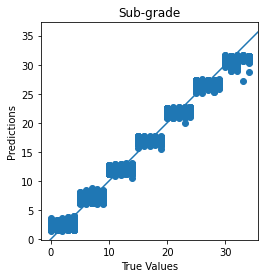

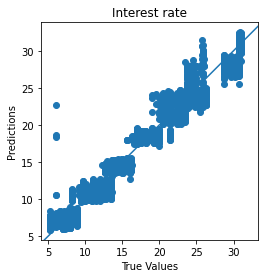

In [ ]:
Y_pred = model.predict(norm_test_X)
price_pred = Y_pred[0]
ptratio_pred = Y_pred[1]

plot_diff(test_Y[0], Y_pred[0], title='Sub-grade')
plot_diff(test_Y[1], Y_pred[1], title='Interest rate')

In [ ]:
model.save('tf_sub_grade_int_rate_model', save_format='tf')

In [ ]:
!tar -czvf tf_model.tar.gz tf_sub_grade_int_rate_model/

tf_sub_grade_int_rate_model/
tf_sub_grade_int_rate_model/variables/
tf_sub_grade_int_rate_model/variables/variables.index
tf_sub_grade_int_rate_model/variables/variables.data-00000-of-00001
tf_sub_grade_int_rate_model/assets/
tf_sub_grade_int_rate_model/keras_metadata.pb
tf_sub_grade_int_rate_model/saved_model.pb


In [ ]:
# or saving to google cloud
from google.colab import files
files.download('tf_model.tar.gz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("sub_grade_model.h5")